# Generative Adversarial Networks

We are moving from descriminative learning with classifiers and regressors to generative learning. It opens up a new area of possibilities in neural networks.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Dense, Flatten, Reshape,
                                     Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization)
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

2025-01-30 10:11:46.859577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Datasets

In [9]:
(train_images, train_labels), (_, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

Generator

In [2]:
def make_generator_model():
    model = keras.Sequential()

    # Foundation for 7x7 image
    model.add(Dense(7 * 7 * 256, activation='relu', input_shape=(NOISE_DIM,)))
    model.add(Reshape((7, 7, 256)))

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Upsample to 28x28
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                              activation='tanh'))  # Single channel for grayscale MNIST images

    return model

Discriminator

In [3]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(1))  # No activation here since we use from_logits=True in the loss

    return model

In [4]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [5]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Model training

In [6]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

Prediction function

In [7]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = tf.reshape(predictions, (-1, 28, 28))  # Reshape to [batch_size, 28, 28]

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

Model Training

In [11]:
# Hyperparameters
BUFFER_SIZE = 60000
BATCH_SIZE = 256
NOISE_DIM = 100

generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 50

# Train the GAN
train(train_dataset, EPOCHS)

2025-01-30 10:16:43.343857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-30 10:16:43.343928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-01-30 10:16:44.110825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2025-01-30 10:16:44.111346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (th

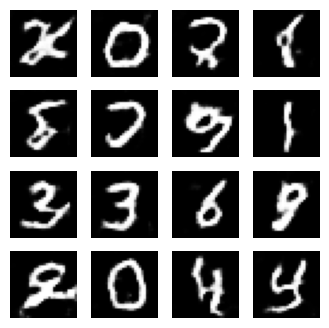

In [13]:
test_input = tf.random.normal([16, NOISE_DIM])
generate_and_save_images(generator, EPOCHS, test_input)

https://medium.com/@marcodelpra/generative-adversarial-networks-dba10e1b4424